In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import transformers
from transformers import pipeline
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import numpy as np
import nltk.data
from requests_html import HTMLSession

In [2]:
url = 'https://ca.finance.yahoo.com/crypto'
response = requests.get(url)
page_content = response.text
doc = BeautifulSoup(page_content, 'html.parser')

# Sentiment analysis on news header

In [3]:
# Model for sentiment analysis
topic_model = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
label = pipeline('sentiment-analysis', model = topic_model)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [4]:
header = []
news_elements = doc.find_all('a', {'class': "js-content-viewer"})
for i in range (len(news_elements)):
    header.append(news_elements[i].text)
news_header_df = pd.DataFrame({'News_Header': header})

In [5]:
classification = []
for i in range (len(news_header_df.News_Header)):
    classification.append(label(news_header_df.News_Header[i]))

In [6]:
labels = []
for i in range (len(classification)):
    labels.append(classification[i][0]['label'])
news_header_df['sentiment_analysis'] = labels

In [7]:
news_header_df.style.applymap(lambda x: f"background: {'red' if x == 'negative' else 'green' if x == 'positive' else 'non'}", subset=['sentiment_analysis'])

,News_Header,sentiment_analysis
0,Bitcoin’s problem may be bond yields,negative
1,El Salvador Diary: Lightning Is Key to Bitcoin Adoption,neutral
2,Cryptocurrency Prices And News: Bitcoin Hits Two-Month Low; SpaceX Abandons Its Crypto,negative
3,"SpaceX Posts Q1 Profit, Abandons Bitcoin Holdings; Cryptocurrencies Crash",negative
4,Bitcoin Pizza Day: Celebrating the $80 Million Pizza Order,neutral
5,Bitcoin Nosedive Jolts Crypto Market Out of Its Summer Stupor,negative
6,Bitcoin price heads higher as US CPI data continues to cool,positive
7,UK watchdog raids 34 sites in crypto ATM crackdown,neutral
8,Bitcoin rally falters as crypto pulls back yet again,negative
9,Bitcoin takes a bath as SEC sues exchange giant Binance,neutral


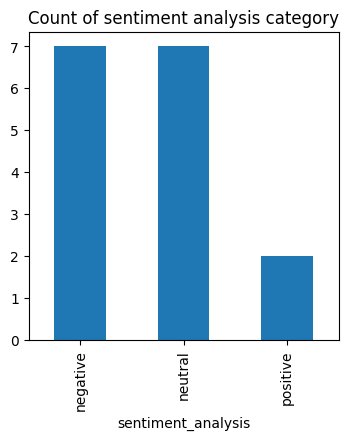

In [8]:
ax = news_header_df['sentiment_analysis'].value_counts().plot(kind = 'bar', figsize = (4,4), title = 'Count of sentiment analysis category')

# Web scrape market data

In [9]:
stock_elements = doc.find('table', {'class' : 'W(100%)'})

In [71]:
stockData=[]
tableTR = stock_elements.find_all('tr')

for i in range (1, len(tableTR)):
    tableTD = tableTR[i].find_all('td')
    name = tableTD[1].text
    price = tableTD[2].text
    change = tableTD[3].text
    change_per = tableTD[4].text
    volume = tableTD[6].text
    stockData.append([name, price, change, change_per, volume])

columns = ["Name", "Price", "Up_or_down", "Up_or_down_percent", "Volume"]
stockData_df = pd.DataFrame(stockData, columns=columns)

# Visuals of stockData_df

In [72]:
# data cleaning
price_to_num = []
for x in range(len(stockData_df)):
    price_to_num.append(stockData_df['Price'][x].replace(',', ''))
#stockData_df = stockData_df.replace(['Pyspark'],'Spark')
stockData_df['Price'] = price_to_num

volume_to_num = []
for x in range(len(stockData_df)):
    if 'B' in stockData_df['Volume'][x]:
        temp = stockData_df['Volume'][x].replace('B', '')
        temp = float(temp) * (10 ** 9)
    else: 
        temp = stockData_df['Volume'][x].replace('M', '')
        temp = float(temp) * (10 ** 6)
    volume_to_num.append(temp)
stockData_df['Volume'] = volume_to_num

stockData_df['Price'] = stockData_df['Price'].astype(float)
stockData_df['Up_or_down'] = stockData_df['Up_or_down'].astype(float)

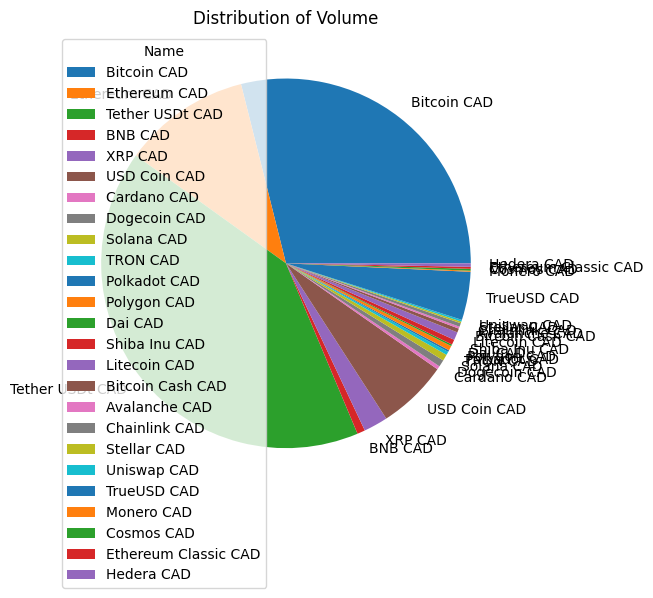

In [81]:
plt.figure(figsize=(10,6))
plt.title('Distribution of Volume')
plt.pie(stockData_df['Volume'], labels = stockData_df['Name'])
plt.legend(title="Name", loc="best",)
plt.show()

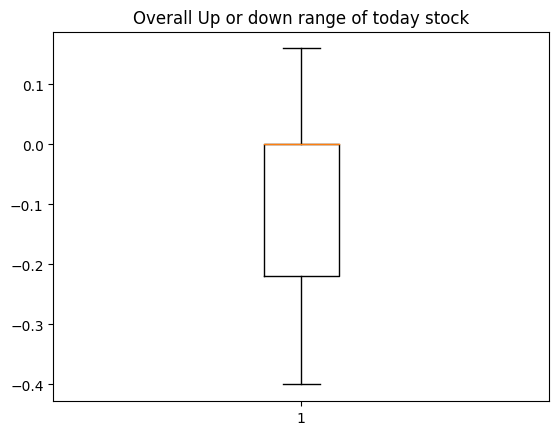

In [29]:
plt.boxplot(stockData_df['Up_or_down'], showfliers=False)
plt.title('Overall Up or down range of today stock')
plt.show()

In [36]:
def up_down_color(value):
  if '+' in value:
    color = 'green'
  elif '-' in value:
    color = 'red'
  else:
    color = 'non'

  return 'color: %s' % color

In [38]:
stockData_df.style.applymap(up_down_color, subset=['Up_or_down_percent'])

,Name,Price,Up_or_down,Up_or_down_percent,24Hr_Volume
0,Bitcoin CAD,"35,208.02",-485.19,-1.36%,27.774B
1,Ethereum CAD,"2,252.33",-13.78,-0.61%,10.717B
2,Tether USDt CAD,1.3565,-0.0003,-0.02%,39.45B
3,BNB CAD,292.74,+0.54,+0.18%,630.776M
4,XRP CAD,0.686931,+0.019248,+2.88%,2.353B
5,USD Coin CAD,1.3570,-0.0002,-0.02%,5.859B
6,Cardano CAD,0.355916,+0.005810,+1.66%,292.461M
7,Dogecoin CAD,0.086614,+0.003686,+4.45%,576.952M
8,Solana CAD,29.23,-0.05,-0.19%,491.838M
9,TRON CAD,0.099618,+0.001529,+1.56%,257.957M
